### Wrinkle Detection
#### U-net w. f-1 loss
* https://datalab.snu.ac.kr/datalab-internal/gpu-status/

### warhol2
* `jupyter lab --ip=147.46.216.82 --NotebookApp.password='sha1:6d8bb616ac21:dc1b7ebffd85cb159379a282c6b49e6121e0ffb1'`

In [1]:
import torch
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memoy_cached())

4
GeForce GTX 1080 Ti
True


In [3]:
import argparse

import os
import csv
import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from unet.model import UNet
from unet.dataset import *
from unet.util import *
from unet.train import train
from unet.evaluate import evaluate
from unet.loss import f1_loss, weighted_loss_and_f1_loss

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def print_log(lr, batch_size, num_epoch, loss_name, data_dir, ckpt_dir, log_dir, mode, device, train_continue):
    time = datetime.datetime.today()
    time = time.strftime('%m-%d_%H-%M')
    time_and_loss = time + "_" + loss_name
    if ckpt_dir == "./checkpoint":
        ckpt_dir = os.path.join(ckpt_dir, time_and_loss)
    log_dir = os.path.join(log_dir, time_and_loss)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        
    print(f'tensorboard --logdir {log_dir} --host "147.46.216.82" --port 6006')
    
    # log parameters
    print("learning rate: %.4e" % lr)
    print("batch size: %d" % batch_size)
    print("number of epoch: %d" % num_epoch)
    print("loss function : %s" % loss_name)
    print("data dir: %s" % data_dir)
    print("ckpt dir: %s" % ckpt_dir)
    print("log dir: %s" % log_dir)
    print("mode: %s" % mode)
    print("device: %s" % device)
    print("train_continue: %s" % train_continue)
    f = open(os.path.join(log_dir, 'parameter.txt'), 'w')
    f.write("learning rate: %.4e\n" % lr)
    f.write("batch size: %d\n" % batch_size)
    f.write("number of epoch: %d\n" % num_epoch)
    f.write("loss function : %s\n" % loss_name)
    f.write("data dir: %s\n" % data_dir)
    f.write("ckpt dir: %s\n" % ckpt_dir)
    f.write("log dir: %s\n" % log_dir)
    f.write("mode: %s\n" % mode)
    f.write("device: %s\n" % device)
    f.write("train_continue: %s\n" % train_continue)
    f.close()
    return log_dir

In [5]:
def train_unet(data_dir, loss_name='weighted_BCE', lr=1e-3, batch_size=8, num_epoch=300, ckpt_dir="./checkpoint", log_dir="./log", mode="train", train_continue="off"):
    
    train_transform = transforms.Compose([RandomResizedCrop(ratio=0.3), Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
    val_transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

    dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

    dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=val_transform)
    loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

    num_data_train = len(dataset_train)
    num_data_val = len(dataset_val)

    num_batch_train = np.ceil(num_data_train / batch_size)
    num_batch_val = np.ceil(num_data_val / batch_size)

    
    if loss_name == "BCE":
        loss_function = nn.BCEWithLogitsLoss().to(device)
    elif loss_name == "weighted_BCE":
        loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5])).to(device)  # 237 - > 59 -> 15
    elif loss_name == "f1":
        loss_function = f1_loss
    elif loss_name =="mix":
        mix_class = weighted_loss_and_f1_loss(nn.BCEWithLogitsLoss(pos_weight=torch.tensor([15])).to(device))
        loss_function = mix_class.loss
    else:
        assert False, loss_name + " is not supported"
        
    log_dir = print_log(lr, batch_size, num_epoch, loss_name, data_dir, ckpt_dir, log_dir, mode, device, train_continue)
        
    net = UNet()
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)
    
    optim = torch.optim.Adam(net.parameters(), lr=lr)

    writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
    writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

    train_f = open(os.path.join(log_dir, 'train.tsv'), 'w', encoding='utf-8', newline='')
    train_wr = csv.writer(train_f, delimiter='\t')
    val_f = open(os.path.join(log_dir, 'val.tsv'), 'w', encoding='utf-8', newline='')
    val_wr = csv.writer(val_f, delimiter='\t')
    train_wr.writerow(["#epoch/loss/acc/f1/tp/tn/fp/fn"])
    val_wr.writerow(["#epoch/loss/acc/f1/tp/tn/fp/fn"])

    ## train network
    st_epoch = 0

    if train_continue == "on":
        net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

    for epoch in range(st_epoch, st_epoch + num_epoch):
        net.train()
        loss, acc, f1, tp, tn, fp, fn = train(net, loader_train, loss_function, num_batch_train, epoch, writer_train, device, optim)
        train_wr.writerow((epoch, loss, acc, f1, tp, tn, fp, fn))

        loss, acc, f1, tp, tn, fp, fn = evaluate(net, loader_val, loss_function, num_batch_val, epoch, writer_val, device)
        val_wr.writerow((epoch, loss, acc, f1, tp, tn, fp, fn))

        if ((epoch+1) % (num_epoch / 10)) == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch+1)
        print("------------------------------------------------------------")

    writer_train.close()
    writer_val.close()
    train_f.close()
    val_f.close()
    
    return net, log_dir

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn

def plot_f1(logs):
    markers = ("o", "x", "s", "^")
    colors = ('dodgerblue','mediumseagreen', 'hotpink', '#fba84a')
    
    def plot_train():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('F1 Score - Train', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[3].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[3].to_numpy()
            plt.plot(train, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('f1 score', fontsize=15)
        plt.show()
    def plot_val():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('F1 Score - Validation', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[3].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[3].to_numpy()
            plt.plot(val, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('f1 score', fontsize=15)
        plt.show()
    plot_train()
    plot_val()
    
def plot_loss(logs):
    markers = ("o", "x", "s", "^")
    colors = ('dodgerblue','mediumseagreen', 'hotpink', '#fba84a')
    
    def plot_train():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('Loss - Train', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[1].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[1].to_numpy()
            plt.plot(train, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('loss', fontsize=15)
        plt.show()
    def plot_val():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('Loss - Validation', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[1].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[1].to_numpy()
            plt.plot(val, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('loss', fontsize=15)
        plt.show()
    plot_train()
    plot_val()

### U-net baseline
* `train_unet(data_dir, loss_name)`
  * Loss function: `BCE`, `weight_BCE`, `f1`, `mix`

### ***Eye***
![](../data/eye_data/train/0014_f_58_20_brow_lower_tex_l.jpg)
![](../data/eye_data/train/0014_f_58_20_brow_lower_tex_r.jpg)

In [8]:
eye_logs = {}
eye_models = {}

In [8]:
for loss in ('BCE', 'weighted_BCE', 'f1', 'mix'):
    eye_models[loss], eye_logs[loss] = train_unet("../data/eye_data/", loss, num_epoch=200, batch_size=50)

tensorboard --logdir ./log/11-30_23-40_BCE --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 50
number of epoch: 1
loss function : BCE
data dir: ../data/eye_data/
ckpt dir: ./checkpoint/11-30_23-40_BCE
log dir: ./log/11-30_23-40_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0018 | LOSS 0.8683 | ACC 0.7449 | F1 SCORE 0.0498 | TIME 11.9909
TRAIN: EPOCH 0000 | BATCH 0002 / 0018 | LOSS 0.8331 | ACC 0.6682 | F1 SCORE 0.0556 | TIME 12.4939
TRAIN: EPOCH 0000 | BATCH 0003 / 0018 | LOSS 0.7407 | ACC 0.9396 | F1 SCORE 0.0491 | TIME 12.9563
TRAIN: EPOCH 0000 | BATCH 0004 / 0018 | LOSS 0.6662 | ACC 0.9391 | F1 SCORE 0.0526 | TIME 13.4242
TRAIN: EPOCH 0000 | BATCH 0005 / 0018 | LOSS 0.6078 | ACC 0.9460 | F1 SCORE 0.0549 | TIME 13.8780
TRAIN: EPOCH 0000 | BATCH 0006 / 0018 | LOSS 0.5481 | ACC 0.9553 | F1 SCORE 0.0485 | TIME 14.3436
TRAIN: EPOCH 0000 | BATCH 0007 / 0018 | LOSS 0.5259 | ACC 0.9610 | F1 SCORE 0.0497 | TIME 14.8894
TRAIN: EP

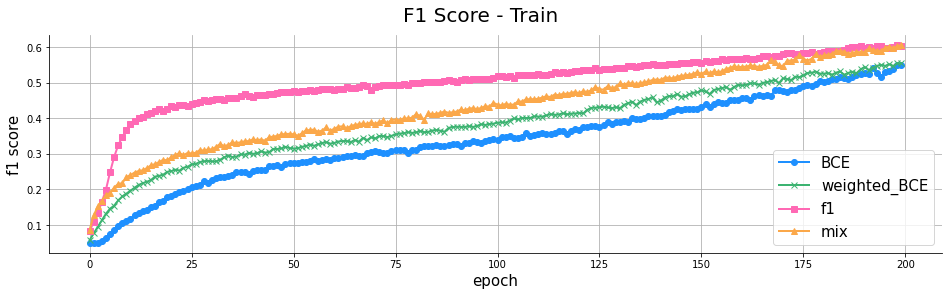

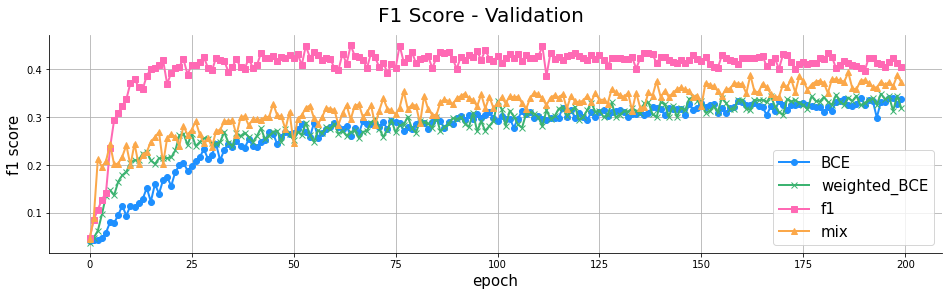

In [9]:
plot_f1(eye_logs)

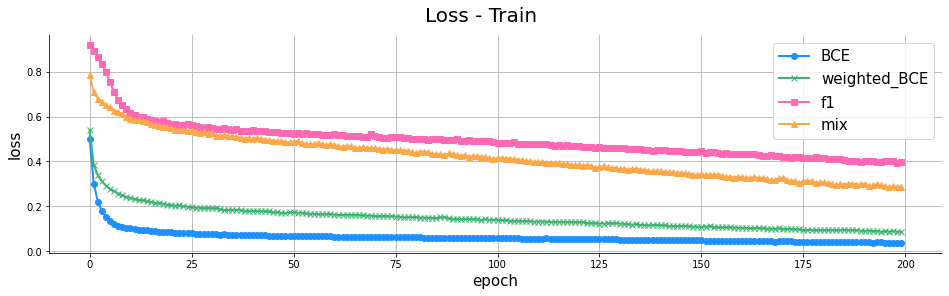

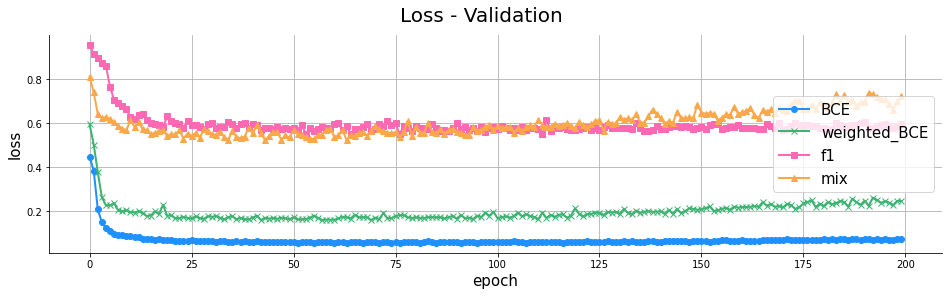

In [10]:
plot_loss(eye_logs)

### ***Upper Face***
![](../data/upper_face_data/train/0005_f_45_18_eye_closed_tex.jpg)

In [10]:
upper_logs = {}
upper_models = {}

In [ ]:
for loss in ('BCE', 'weighted_BCE', 'f1', 'mix'):
    upper_models[loss], upper_logs[loss] = train_unet("../data/upper_face_data/", loss, num_epoch=200, batch_size=10)

tensorboard --logdir ./log/12-01_10-51_BCE --host "147.46.216.82" --port 6006
learning rate: 1.0000e-03
batch size: 10
number of epoch: 200
loss function : BCE
data dir: ../data/upper_face_data/
ckpt dir: ./checkpoint/12-01_10-51_BCE
log dir: ./log/12-01_10-51_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0044 | LOSS 0.7308 | ACC 0.9160 | F1 SCORE 0.0061 | TIME 14.8988
TRAIN: EPOCH 0000 | BATCH 0002 / 0044 | LOSS 0.7088 | ACC 0.8975 | F1 SCORE 0.0091 | TIME 15.7256
TRAIN: EPOCH 0000 | BATCH 0003 / 0044 | LOSS 0.6230 | ACC 0.9851 | F1 SCORE 0.0061 | TIME 16.3190
TRAIN: EPOCH 0000 | BATCH 0004 / 0044 | LOSS 0.5758 | ACC 0.9607 | F1 SCORE 0.0053 | TIME 16.9319
TRAIN: EPOCH 0000 | BATCH 0005 / 0044 | LOSS 0.5163 | ACC 0.9874 | F1 SCORE 0.0031 | TIME 17.5496
TRAIN: EPOCH 0000 | BATCH 0006 / 0044 | LOSS 0.4769 | ACC 0.9901 | F1 SCORE 0.0039 | TIME 18.1654
TRAIN: EPOCH 0000 | BATCH 0007 / 0044 | LOSS 0.4812 | ACC 0.9930 | F1 SCORE 0.0000 | TIME 18.7661
TRAI

In [16]:
upper_logs

{'BCE': './log/11-30_23-52_BCE',
 'weighted_BCE': './log/12-01_00-48_weighted_BCE',
 'f1': './log/12-01_01-44_f1',
 'mix': './log/12-01_02-40_mix'}

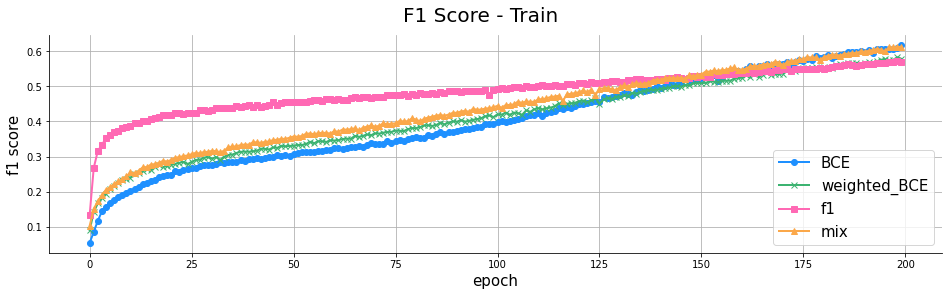

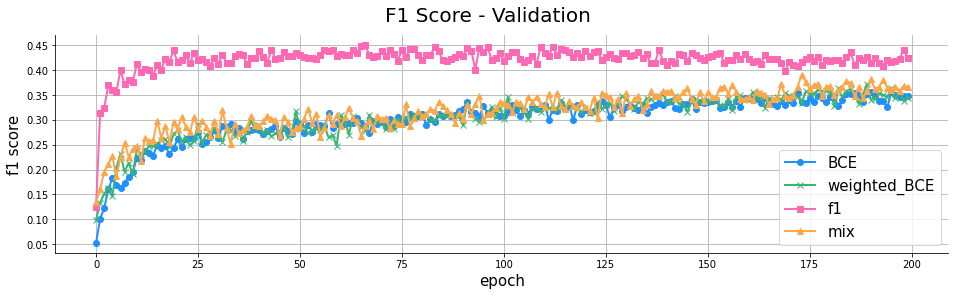

In [17]:
plot_f1(upper_logs)

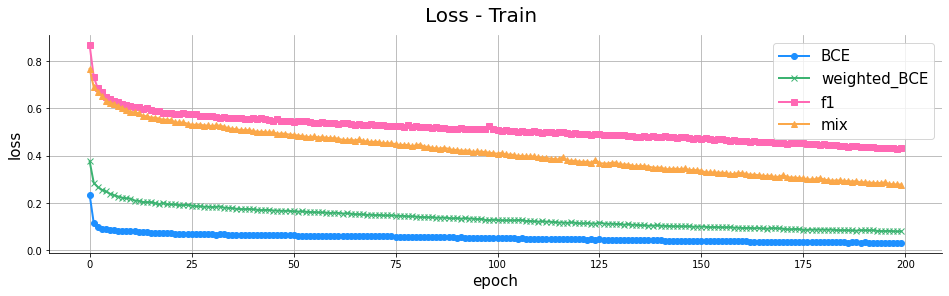

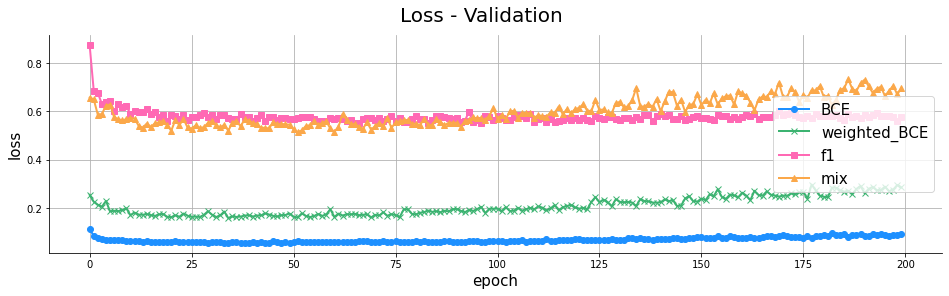

In [18]:
plot_loss(upper_logs)

### ***Lower Face***
![](../data/lower_face_data/train/0017_m_31_17_cheek_blowing_tex.jpg)

In [ ]:
lower_logs = {}
lower_models = {}

In [6]:
for loss in ('BCE', 'weighted_BCE', 'f1', 'mix'):
    lower_models[loss], lower_logs[loss] = train_unet("../data/lower_face_data/", loss, num_epoch=200, batch_size=5)

tensorboard --logdir ./log/11-30_15-56_BCE --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 5
number of epoch: 10
loss function : BCE
data dir: ../data/lower_face_data/
ckpt dir: ./checkpoint/11-30_15-56_BCE
log dir: ./log/11-30_15-56_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0088 | LOSS 0.9122 | ACC 0.7417 | F1 SCORE 0.0156 | TIME 9.7058
TRAIN: EPOCH 0000 | BATCH 0002 / 0088 | LOSS 0.8469 | ACC 0.7986 | F1 SCORE 0.0093 | TIME 10.5053
TRAIN: EPOCH 0000 | BATCH 0003 / 0088 | LOSS 0.7892 | ACC 0.9240 | F1 SCORE 0.0114 | TIME 11.1075
TRAIN: EPOCH 0000 | BATCH 0004 / 0088 | LOSS 0.6867 | ACC 0.9489 | F1 SCORE 0.0196 | TIME 11.7130
TRAIN: EPOCH 0000 | BATCH 0005 / 0088 | LOSS 0.6485 | ACC 0.9666 | F1 SCORE 0.0142 | TIME 12.3060
TRAIN: EPOCH 0000 | BATCH 0006 / 0088 | LOSS 0.5991 | ACC 0.9754 | F1 SCORE 0.0133 | TIME 12.9055
TRAIN: EPOCH 0000 | BATCH 0007 / 0088 | LOSS 0.5538 | ACC 0.9857 | F1 SCORE 0.0107 | TIME 13.5217
TRA

In [ ]:
plot_f1(lower_logs)

In [ ]:
plot_loss(lower_logs)